In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Récapépète

- Transformée de Fourier d'un signal discret $s(n)$

$S(k) = \sum_{n=0}^{N-1} s(n)e^{-2ik\pi\frac{n}{N}} = \sum_{n=0}^{N-1} s(n)(\cos(-2ik\pi\frac{n}{N}) + j\sin(-2ik\pi\frac{n}{N}))$

$\forall k, 0 \leqslant k < N$

- Petite vidéo sur le loop free, avec lois de broadcasting : 
https://www.youtube.com/watch?v=EEUXKG97YRw

- Si tu te pose la question pourquoi $2\pi ft$ donne un sinus avec une fréquence $f$ :
    - $2\pi$ veut dire que tu parcours tout le cercle
    - $t$ c'est l'inclusion de ta dimension temporelle
    - $2\pi ft$ tu parcours le cercle dans le temps à la "vitesse" f
    - En physique, on note $\omega = 2\pi f$ la vitesse de rotation

In [2]:
def pure_sine(n, sf=128., f=10., phi=30., amp=1., sin=True):
    """Pure sine function."""
    t = np.arange(n) / sf
    fun = np.sin if sin else np.cos
    return fun(2 * np.pi * f * t + np.deg2rad(phi)), t

# Fréquence centrale $\neq$ dephasage

Je pense que ce serait bien que tu expliques la différence entre fréquence principale ($f$) et déphasage ($\phi$) dans le terme $2\pi ft + \phi$

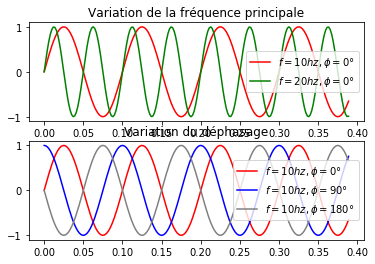

In [3]:
n = 200
sf = 512.
x_10, t = pure_sine(n, sf, phi=0.)
x_20, _ = pure_sine(n, sf, phi=0., f=20.)
x_10_depha, _ = pure_sine(n, sf, phi=90)
x_10_depha_2, _ = pure_sine(n, sf, phi=180)

plt.figure(1)
plt.subplot(211)
plt.plot(t, x_10, color='red', label=r'$f=10hz, \phi = 0°$')
plt.plot(t, x_20, color='green', label=r'$f=20hz, \phi = 0°$')
plt.title("Variation de la fréquence principale")
plt.legend()

plt.subplot(212)
plt.plot(t, x_10, color='red', label=r'$f=10hz, \phi = 0°$')
plt.plot(t, x_10_depha, color='blue', label=r'$f=10hz, \phi = 90°$')
plt.plot(t, x_10_depha_2, color='gray', label=r'$f=10hz, \phi = 180°$')
plt.title("Variation du déphasage")
plt.legend()

# Précision sur la fréquence principale du sinus

L'idée de cette partie est d'illustrer que l'estimation fréquentielle dépend du nombre de points composant le signal (ou nombre de cycle du sinus).

Text(0.5,1,"Estimation de la fréquence principale d'un sinus en fonction \ndu nombre de points le composant")

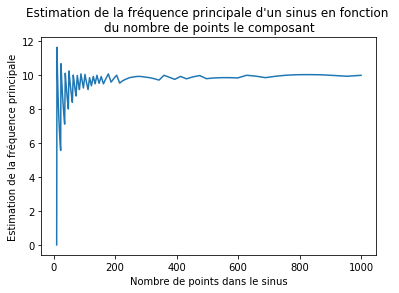

In [4]:
sf = 128.
f_log = np.logspace(1, 3, 100).astype(int)
f_close = np.zeros(len(f_log), dtype=float)

for i, k in enumerate(f_log):
    r = slice(0, int(k/2))
    # On définit un sinus de longeur k :
    sine, _ = pure_sine(k, sf)
    # On calcul la fft + vecteur fréquence :
    fft_sine = np.fft.fft(sine)[r]
    f_vec = np.fft.fftfreq(k, d=1/sf)[r]
    # On récupère la fréquence à laquelle la fft est max :
    f_close[i] = f_vec[np.argmax(fft_sine)]

plt.figure(2)
plt.plot(f_log, f_close)
plt.xlabel("Nombre de points dans le sinus")
plt.ylabel("Estimation de la fréquence principale")
plt.title("Estimation de la fréquence principale d'un sinus en fonction \ndu nombre de points le composant")

# Lien entre sinus et cosinus

$\cos = \sin + \pi / 2$

cosine = sine + pi/2 :  True


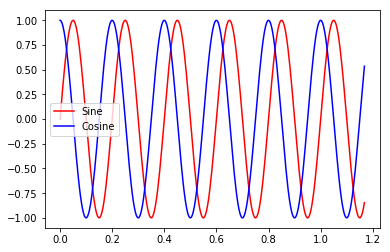

In [5]:
n = 300
sf = 256.
x_sin, t = pure_sine(n, sf, f=5., phi=0.)
x_cos, _ = pure_sine(n, sf, f=5., phi=0., sin=False)
x_sin_90, t = pure_sine(n, sf, f=5., phi=90.)

print('cosine = sine + pi/2 : ', np.allclose(x_cos, x_sin_90))

plt.figure(45)
plt.plot(t, x_sin, color='red', label='Sine')
plt.plot(t, x_cos, color='blue', label='Cosine')
plt.legend()


# Estimation de la phase

En résumé : 
- La fréquence d'un signal peut être comprise comme la vitesse à laquelle un motif se répète
- Un déphasage :
    - Dans le cercle complexe, ça veut dire que tu incrémentes toute les valeurs d'angle par une constante (ex : si $\phi=\pi / 4$ alors tu ajoutes un quart de cercle à tout tes angles)
    - Dans le plan réel (donc $f(x)$), ça revient à translater ta sinusoïde
    
Maintenant, il y a une subtilité au déphasage. On se déphase toujours par rapport à quelque chose ! Sinon, ce serait comme tracer une droite entre un point ! Hors, la référence, c'est pas le sinus, c'est le cosinus. Donc si ton signal est déphasé, tu vas chercher à savoir de combien par rapport à un cosinus à déphasage nul càd $\cos(2\pi ft + 0)$

Dans notre cas, on a utilisé un sinus donc pour le comparer au cosinus, il faudra ajouter $\pi/2$ à la phase finale.

Déphasage utilisé :  29.99999999999971


(<matplotlib.axes._subplots.AxesSubplot at 0x279c0219860>,
 <Container object of 3 artists>)

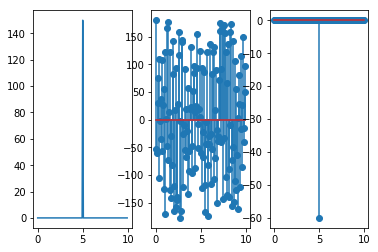

In [6]:
n = 300
sf = 20.
x, t = pure_sine(n, sf, f=5., phi=30.)

# Calcul de la fft :
fft = np.fft.fft(x)[range(int(n/2))]
f = np.fft.fftfreq(n, d=1/sf)[range(int(n/2))]

pha_non = np.angle(fft, deg=True)  # équivalent à np.rad2deg(np.arctan2(fft.imag, fft.real))

# Nettoyage de la phase à cause des valeur imaginaires très basses
# cf : https://www.gaussianwaves.com/2015/11/interpreting-fft-results-obtaining-magnitude-and-phase-information/
threshold = np.max(np.abs(fft)) / 10000.
pha = pha_non.copy()
pha[np.abs(fft) < threshold] = 0.

# On recherche le pic de la fft :
fft_pic = np.argmax(fft)
# On regarde la valeur de la phase à cet endroit :
pha_pic = pha[fft_pic]
# On convertie cette phase en en lui ajoutant pi/2 (ou 90° puisque je suis en radians)
print("Déphasage utilisé : ", pha_pic + 90.)

plt.figure(3)
plt.subplot(131), plt.plot(f, np.abs(fft))
plt.subplot(132), plt.stem(f, pha_non)
plt.subplot(133), plt.stem(f, pha)